Notebook to read and display Embedded Element Patterns for a range of station rotations

It requires local copies of the EEP files. These should be converted to .npy format as described in:<br>
https://developer.skatelescope.org/projects/ska-low-mccs-calibration/en/latest/sky-models.html.<br>
e.g.
    
> from ska_low_mccs_calibration.eep import convert_eep2npy<br>
> convert_eep2npy(f"/path/to/eep/data/FEKO_AAVS3_vogel_256_elem_50ohm_*MHz_?pol.mat", npy_dir="./AAVS3_EEPs_local")<br>

In [1]:
# Imports

import logging
import sys

import matplotlib.pyplot as plt
import numpy as np

from ska_low_mccs_calibration.eep import (
    load_eeps,
    resample_eeps,
)

log = logging.getLogger()
log.setLevel(logging.INFO)
log.addHandler(logging.StreamHandler(sys.stdout))

In [2]:
# Load EEPs
# Requires a local copy of the FEKO models, converted to .npy format as described in
# https://developer.skatelescope.org/projects/ska-low-mccs-calibration/en/latest/sky-models.html
# e.g.
#     from ska_low_mccs_calibration.eep import convert_eep2npy
#     convert_eep2npy(
#         f"/path/to/eep/data/FEKO_AAVS3_vogel_256_elem_50ohm_*MHz_?pol.mat",
#         npy_dir="./AAVS3_EEPs_local",
#     )

eep_file_path = "./AAVS3_EEPs_local"
eep_file_base = "FEKO_AAVS3_vogel_256_elem_50ohm_"

# frequency channel to read
channel_id = 140
channel_bw_MHz = 400.0 / 512.0
frequency_MHz = float(channel_id) * channel_bw_MHz

raw_EEPs = load_eeps(frequency_MHz, eep_file_path)

In [3]:
# Setup for resampling and plotting

# New sky coordinates
az_deg = np.arange(0, 360, 2)
el_deg = np.arange(0, 90, 2)
Naz = len(az_deg)
Nel = len(el_deg)
azimuth_deg, elevation_deg = np.meshgrid(az_deg, el_deg)
azimuth_deg = azimuth_deg.flatten()
elevation_deg = elevation_deg.flatten()

def plotEEP(nrow, ncol, panel, img, label):
    ax = plt.subplot(nrow, ncol, panel, polar=True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(label)
    plt.pcolormesh(
        np.pi / 2 - azimuth_deg[:Naz] * np.pi / 180.0,
        np.pi / 2 - elevation_deg[::Naz] * np.pi / 180.0,
        np.abs(img),
    )

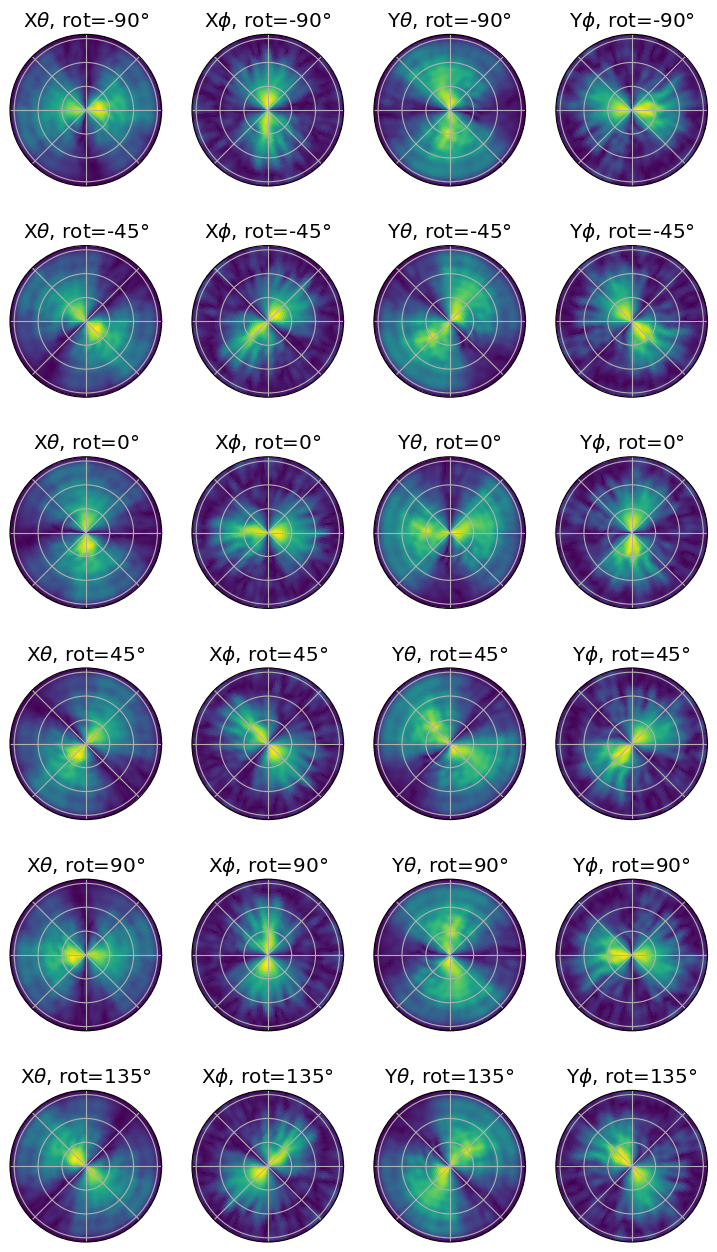

In [4]:
# Resample and plot for different EEP rotations

plt.figure(figsize=[9, 16])
plt.rcParams.update({'font.size': 12})

station = 3

for k, rotation in enumerate(range(-90, 180, 45)):

    EEPs = resample_eeps(raw_EEPs, rotation, azimuth_deg, elevation_deg)

    X_theta = EEPs[0][station].reshape(Nel, Naz)
    X_phi = EEPs[1][station].reshape(Nel, Naz)
    Y_theta = EEPs[2][station].reshape(Nel, Naz)
    Y_phi = EEPs[3][station].reshape(Nel, Naz)

    plotEEP(6, 4, 4 * k + 1, X_theta, fr"X$\theta$, rot={rotation}$\degree$")
    plotEEP(6, 4, 4 * k + 2, X_phi, fr"X$\phi$, rot={rotation}$\degree$")
    plotEEP(6, 4, 4 * k + 3, Y_theta, fr"Y$\theta$, rot={rotation}$\degree$")
    plotEEP(6, 4, 4 * k + 4, Y_phi, fr"Y$\phi$, rot={rotation}$\degree$")

# plt.savefig("EEP_rotations.png", dpi=300, format="png")

In [5]:
# Compare a few different EEP rotations and make sure they're equivalent (as in test_rotate_eeps)

EEPs000 = resample_eeps(raw_EEPs, 0, azimuth_deg, elevation_deg)
EEPs090 = resample_eeps(raw_EEPs, 90, azimuth_deg, elevation_deg)
EEPs180 = resample_eeps(raw_EEPs, 180, azimuth_deg, elevation_deg)

iaz = np.arange(Naz)
assert len(EEPs000) == 4
for pol in range(len(EEPs000)):
    assert EEPs000[pol].shape[0] == 256
    for stn in range(EEPs000[pol].shape[0]):
        XX000 = EEPs000[pol][stn].reshape(Nel, Naz)
        XX090 = EEPs090[pol][stn].reshape(Nel, Naz)
        XX180 = EEPs180[pol][stn].reshape(Nel, Naz)
        assert np.max(np.abs(XX000 - XX090[:, (Naz // 4 + iaz) % Naz])) < 1e-7
        assert np.max(np.abs(XX000 - XX180[:, (Naz // 2 + iaz) % Naz])) < 1e-7